# Initial Imports and Constants

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib
import os

In [3]:
### Define data directory
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data")
print(f"Data directory: {data_dir}")

Data directory: /Users/pentrican10/Projects/tess-resonant-systems/data


In [4]:
### switch to mask out transits
mask_transits = True
### set range for search: [#hours] * [days per hour]
ttv_hour = 24*2* 0.0416667 # 1 hour to days

In [5]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

# Get data

In [6]:
TOI_id = 'TOI 216'
search_result = lk.search_lightcurve(TOI_id, author='SPOC')
print(search_result)

# lc_collection = search_result.download_all()
# lc = lc_collection
# lc[0].download()
# lc[1].download()
# lc[2].download()
# lc[3].download()


# lc_collection = lc[0].download()
# lc_collection.append(lc[1].download())
# lc_collection.append(lc[3].download())

SearchResult containing 64 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120    55652896      0.0
  1 TESS Sector 02 2018   SPOC     120    55652896      0.0
  2 TESS Sector 03 2018   SPOC     120    55652896      0.0
  3 TESS Sector 04 2018   SPOC     120    55652896      0.0
  4 TESS Sector 05 2018   SPOC     120    55652896      0.0
  5 TESS Sector 06 2018   SPOC     120    55652896      0.0
  6 TESS Sector 07 2019   SPOC     120    55652896      0.0
  7 TESS Sector 08 2019   SPOC     120    55652896      0.0
  8 TESS Sector 09 2019   SPOC     120    55652896      0.0
...            ...  ...    ...     ...         ...      ...
 54 TESS Sector 61 2023   SPOC     120    55652896      0.0
 55 TESS Sector 65 2023   SPOC     120    55652896      0.0
 56 TESS Sector 87 2024   SPOC      20    55652896      0

In [77]:
print(search_result.table['mission'])
# Extract the 'mission' column
missions = search_result.table['mission']

# Extract just the sector numbers (as strings)
sector_numbers = [m.replace("TESS Sector ", "") for m in missions]

# Optionally, convert to integers (helps with sorting and duplicates)
sector_numbers = [int(s) for s in sector_numbers]

# Get the set of unique sector numbers
unique_sectors = set(sector_numbers)

# Print the count and optionally the sorted list
print(f"Number of unique sectors: {len(unique_sectors)}")
print(f"Unique sectors: {sorted(unique_sectors)}")

   mission    
--------------
TESS Sector 01
TESS Sector 02
TESS Sector 03
TESS Sector 04
TESS Sector 05
TESS Sector 06
TESS Sector 07
TESS Sector 08
TESS Sector 09
TESS Sector 11
           ...
TESS Sector 61
TESS Sector 65
TESS Sector 87
TESS Sector 87
TESS Sector 89
TESS Sector 90
TESS Sector 88
TESS Sector 89
TESS Sector 88
TESS Sector 90
Length = 64 rows
Number of unique sectors: 38
Unique sectors: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 61, 62, 63, 64, 65, 66, 67, 68, 69, 87, 88, 89, 90]


In [7]:
lc_collection = search_result.download_all()
# lc_collection.plot()
# plt.show()
print(lc_collection)

LightCurveCollection of 64 objects:
    0: <TessLightCurve LABEL="TIC 55652896" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 55652896" SECTOR=2 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 55652896" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 55652896" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 55652896" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 55652896" SECTOR=6 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 55652896" SECTOR=7 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 55652896" SECTOR=8 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 55652896" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 55652896" SECTOR=11 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 55652896" SECTOR=12 AUTHOR=S

In [8]:
clean_lcs = [lc[lc.quality == 0] for lc in lc_collection]


In [9]:
# Normalize, flatten, and remove outliers
processed_lcs = [
    lc.normalize().flatten(window_length=401).remove_outliers(sigma=5)
    for lc in clean_lcs
]

In [10]:
# Stitch into one combined light curve
combined_lc = processed_lcs[0]
for lc in processed_lcs[1:]:
    combined_lc = combined_lc.append(lc)



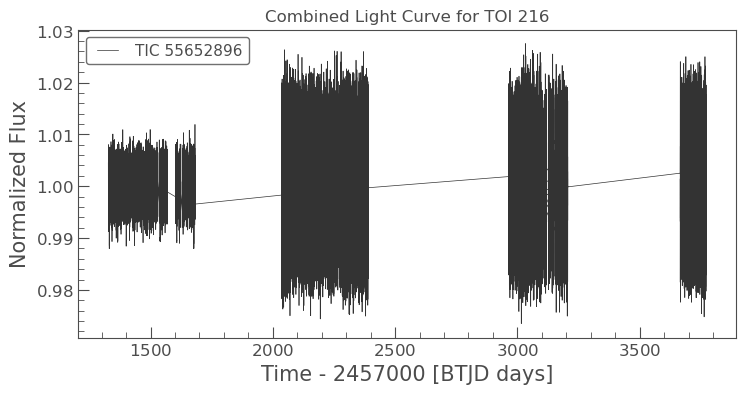

In [11]:
combined_lc.plot()
plt.title(f"Combined Light Curve for {TOI_id}")
plt.show()

In [12]:
# Extract useful data arrays
time = combined_lc.time.value
flux = combined_lc.flux.value
flux_err = combined_lc.flux_err.value
print(time)
print(flux)

[1327.31399694 1327.31538585 1327.31677476 ... 3772.01147866 3772.01286754
 3772.01425642]
[1.004527   1.00061245 0.99753448 ... 1.00453794 1.00002416 0.99747423]


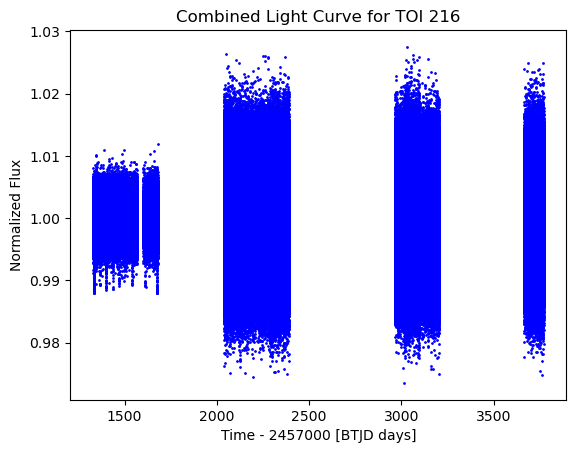

In [13]:
plt.scatter(time, flux, s=1, c='b')
plt.title(f'Combined Light Curve for {TOI_id}')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# BLS Runs

## BLS 1

`period` contains 233085 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


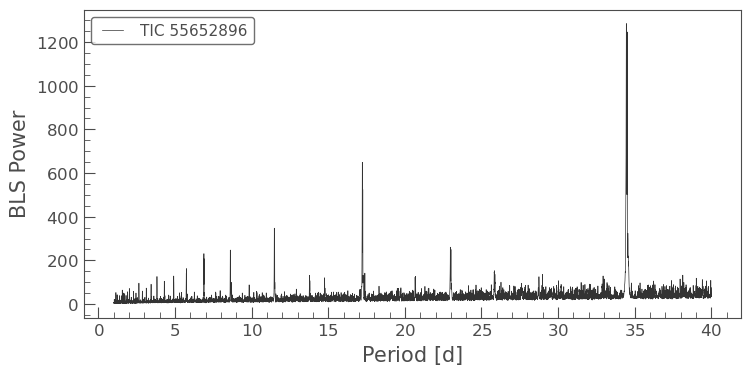

In [14]:
bls_1 = combined_lc.to_periodogram(method='bls', period=np.linspace(1.0, 40, 10000), frequency_factor=500)
bls_1.plot()
plt.show()


In [15]:
planet_1_period = bls_1.period_at_max_power
planet_1_dur = bls_1.duration_at_max_power
planet_1_t0 = bls_1.transit_time_at_max_power

print(f"Best candidate period: {planet_1_period.value:.5f} days")
print(f"Best candidate t0: {planet_1_t0.value:.5f} days")

Best candidate period: 34.44974 days
Best candidate t0: 1332.91900 days


In [16]:
import numpy as np
from scipy.signal import find_peaks

# 1. Access full power array
powers = bls_1.power.value
periods = bls_1.period.value
durations = bls_1.duration.value
t0s = bls_1.transit_time.value

# 2. Find all peaks in the BLS power spectrum
peaks, _ = find_peaks(powers)

# 3. Sort peaks by power (descending)
sorted_peaks = peaks[np.argsort(powers[peaks])[::-1]]

# 4. Get top 3 signal indices
top_indices = sorted_peaks[:7]

# 5. Extract their periods, durations, and t0s
top_periods = periods[top_indices]
top_durations = durations[top_indices]
top_t0s = t0s[top_indices]
top_powers = powers[top_indices]

# 6. Print results
for i in range(7):
    print(f"Signal {i+1}:")
    print(f"  Period:   {top_periods[i]:.5f} days")
    print(f"  T0:       {top_t0s[i]:.5f}")
    print(f"  Duration: {top_durations[i]:.5f} days")
    print(f"  Power:    {top_powers[i]:.5f}")
    print("-" * 30)


Signal 1:
  Period:   34.44974 days
  T0:       1332.91900
  Duration: 0.20000 days
  Power:    1284.55781
------------------------------
Signal 2:
  Period:   34.50825 days
  T0:       1331.38900
  Duration: 0.33000 days
  Power:    1245.79225
------------------------------
Signal 3:
  Period:   17.22562 days
  T0:       1332.87900
  Duration: 0.20000 days
  Power:    649.26692
------------------------------
Signal 4:
  Period:   34.48485 days
  T0:       1332.02400
  Duration: 0.33000 days
  Power:    586.74975
------------------------------
Signal 5:
  Period:   17.25293 days
  T0:       1331.43400
  Duration: 0.33000 days
  Power:    525.15482
------------------------------
Signal 6:
  Period:   11.48425 days
  T0:       1332.84400
  Duration: 0.20000 days
  Power:    347.37774
------------------------------
Signal 7:
  Period:   11.49985 days
  T0:       1331.71400
  Duration: 0.33000 days
  Power:    328.24090
------------------------------


In [17]:
# Create a cadence mask using the BLS parameters
planet_1_mask = bls_1.get_transit_mask(period=planet_1_period,
                                     transit_time=planet_1_t0,
                                     duration=planet_1_dur*1.5)

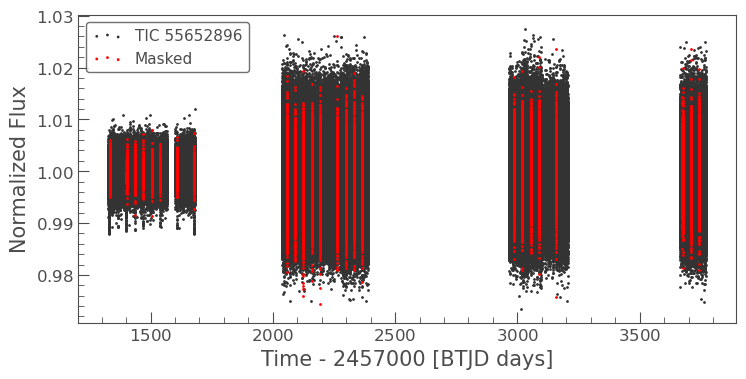

In [18]:
masked_lc_1 = combined_lc[~planet_1_mask]
ax = masked_lc_1.scatter();
combined_lc[planet_1_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [19]:
# Create a BLS model using the BLS parameters
planet_1_model = bls_1.get_transit_model(period=planet_1_period,
                                       transit_time=planet_1_t0,
                                       duration=planet_1_dur)


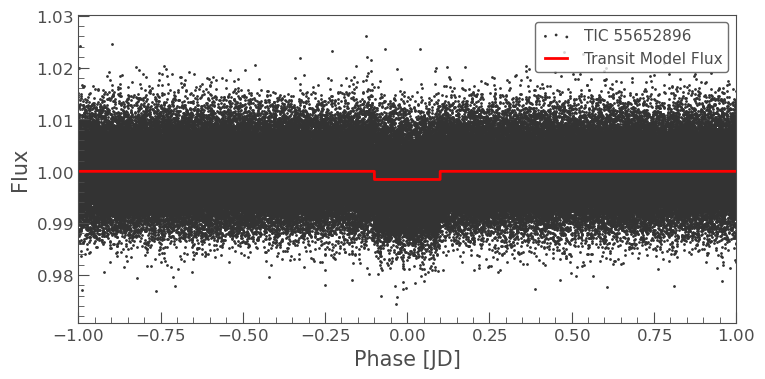

In [20]:
ax = combined_lc.fold(planet_1_period, planet_1_t0).scatter()
planet_1_model.fold(planet_1_period, planet_1_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 2

`period` contains 227109 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


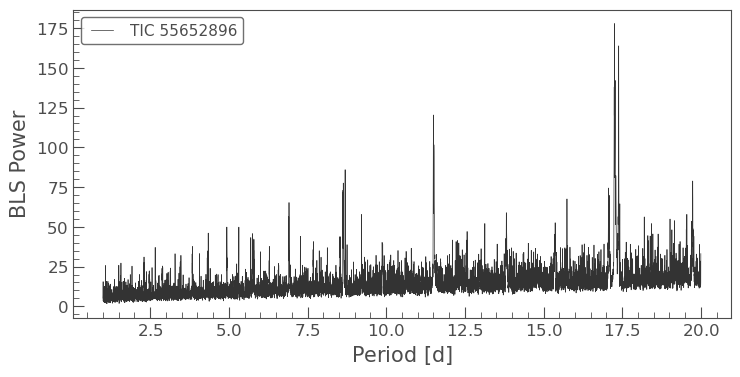

In [21]:
period = np.linspace(1, 20, 10000)
bls_2 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.show()

In [22]:
planet_2_period = bls_2.period_at_max_power
planet_2_t0 = bls_2.transit_time_at_max_power
planet_2_dur = bls_2.duration_at_max_power

print(f"Best candidate period 2: {planet_2_period.value:.5f} days")
print(f"Best candidate t0 2: {planet_2_t0.value:.5f} days")

Best candidate period 2: 17.25423 days
Best candidate t0 2: 1331.38400 days


In [23]:
# ax = masked_lc_1.fold(planet_2_period, planet_2_t0).scatter()
# masked_lc_1.fold(planet_2_period, planet_2_t0).bin(.1).plot(ax=ax, c='r', lw=2,
#                                                           label='Binned Flux')
# ax.set_xlim(-5, 5)
# plt.show()

In [24]:
planet_2_mask = bls_2.get_transit_mask(period=planet_2_period,
                                     transit_time=planet_2_t0,
                                     duration=planet_2_dur*1.5)

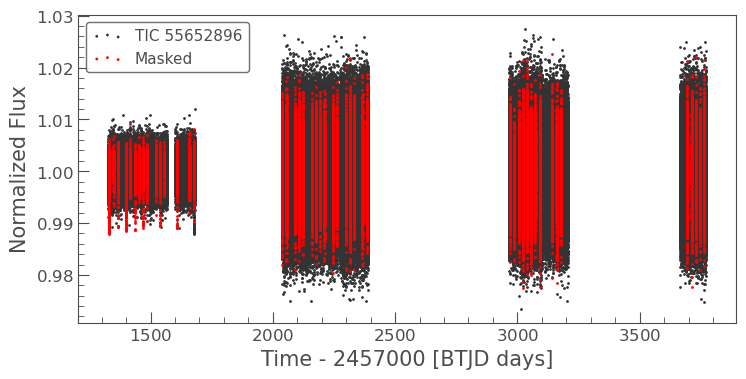

In [25]:
masked_lc_2 = masked_lc_1[~planet_2_mask]
ax = masked_lc_2.scatter();
masked_lc_1[planet_2_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [26]:
planet_2_model = bls_2.get_transit_model(period=planet_2_period,
                                       transit_time=planet_2_t0,
                                       duration=planet_2_dur)

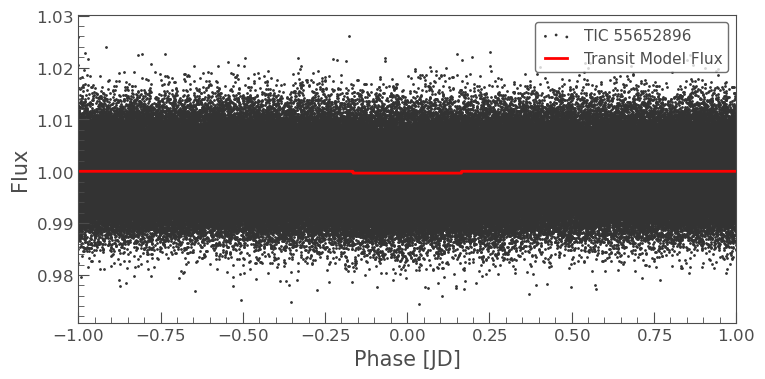

In [27]:
ax = combined_lc.fold(planet_2_period, planet_2_t0).scatter()
planet_2_model.fold(planet_2_period, planet_2_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

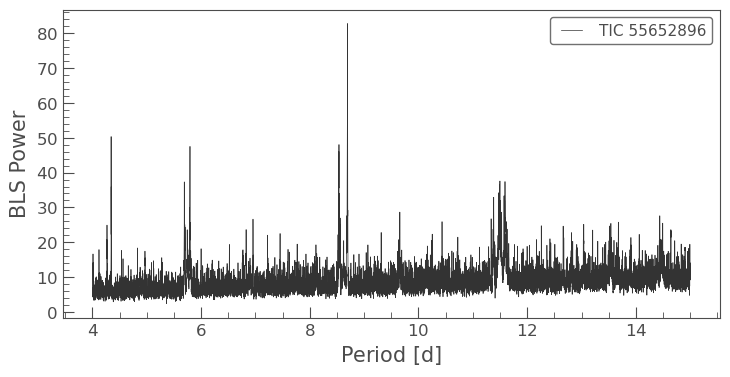

In [28]:
### start period search at 4days to try to find planet e before d
period = np.linspace(4, 15, 10000)
bls_3 = masked_lc_2.to_periodogram('bls', period=period, frequency_factor=500)
bls_3.plot()
plt.show()

In [29]:
planet_3_period = bls_3.period_at_max_power
planet_3_t0 = bls_3.transit_time_at_max_power
planet_3_dur = bls_3.duration_at_max_power

print(f"Best candidate period 3: {planet_3_period.value:.5f} days")
print(f"Best candidate t0 3: {planet_3_t0.value:.5f} days")

Best candidate period 3: 8.69417 days
Best candidate t0 3: 1332.36900 days


In [30]:
planet_3_mask = bls_3.get_transit_mask(period=planet_3_period,
                                     transit_time=planet_3_t0,
                                     duration=planet_3_dur*1.5)


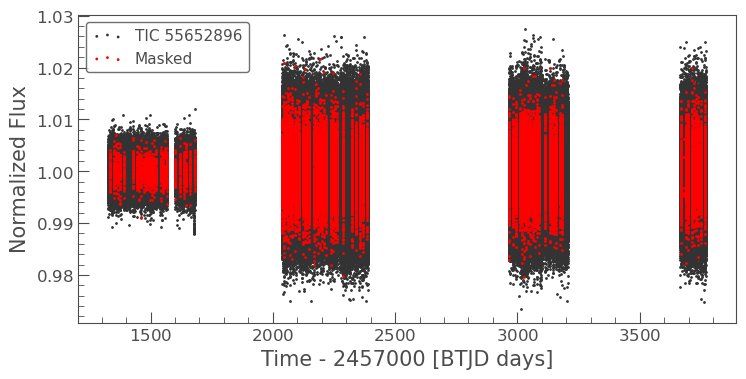

In [31]:
masked_lc_3 = masked_lc_2[~planet_3_mask]
ax = masked_lc_3.scatter();
masked_lc_2[planet_3_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [32]:
planet_3_model = bls_3.get_transit_model(period=planet_3_period,
                                       transit_time=planet_3_t0,
                                       duration=planet_3_dur)

`period` contains 223124 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


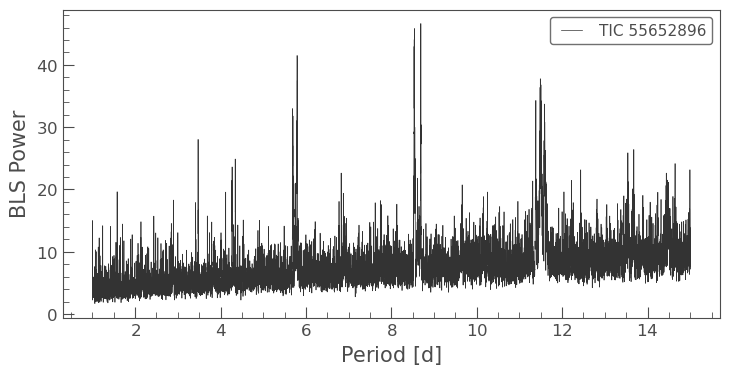

In [33]:
period = np.linspace(1, 15, 10000)
bls_4 = masked_lc_3.to_periodogram('bls', period=period, frequency_factor=500)
bls_4.plot()
plt.show()

In [34]:
planet_4_period = bls_4.period_at_max_power
planet_4_t0 = bls_4.transit_time_at_max_power
planet_4_dur = bls_4.duration_at_max_power

print(f"Best candidate period 4: {planet_4_period.value:.5f} days")
print(f"Best candidate t0 4: {planet_4_t0.value:.5f} days")

Best candidate period 4: 8.69097 days
Best candidate t0 4: 1327.90400 days


In [35]:
planet_4_mask = bls_4.get_transit_mask(period=planet_4_period,
                                     transit_time=planet_4_t0,
                                     duration=planet_4_dur*1.5)


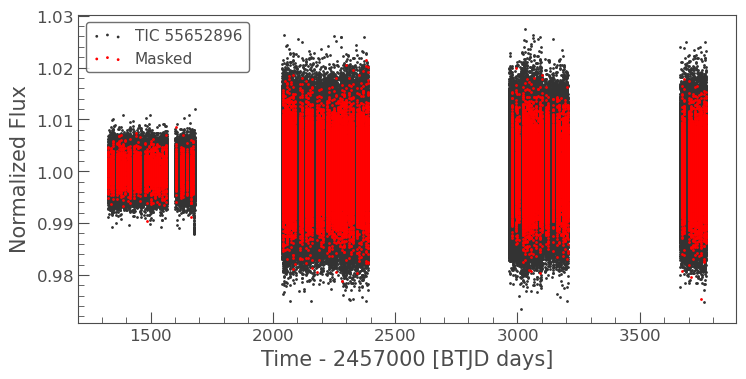

In [36]:
masked_lc_4 = masked_lc_3[~planet_4_mask]
ax = masked_lc_4.scatter();
masked_lc_3[planet_4_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [37]:
planet_4_model = bls_4.get_transit_model(period=planet_4_period,
                                       transit_time=planet_4_t0,
                                       duration=planet_4_dur)

`period` contains 223124 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


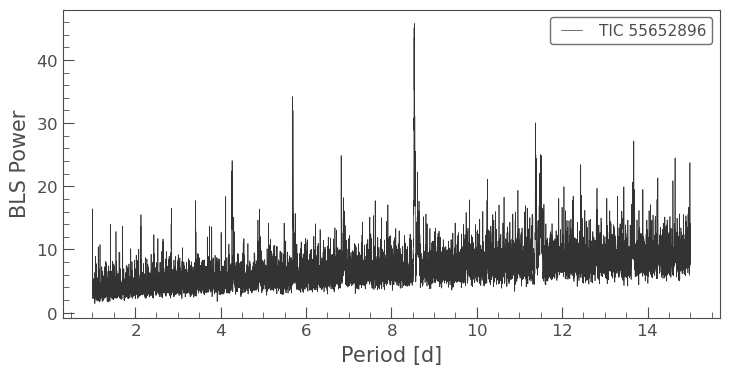

In [38]:
period = np.linspace(1, 15, 10000)
bls_5 = masked_lc_4.to_periodogram('bls', period=period, frequency_factor=500)
bls_5.plot()
plt.show()

In [39]:
planet_5_period = bls_5.period_at_max_power
planet_5_t0 = bls_5.transit_time_at_max_power
planet_5_dur = bls_5.duration_at_max_power

print(f"Best candidate period 5: {planet_5_period.value:.5f} days")
print(f"Best candidate t0 5: {planet_5_t0.value:.5f} days")

Best candidate period 5: 8.54395 days
Best candidate t0 5: 1328.24900 days


In [40]:
planet_5_mask = bls_5.get_transit_mask(period=planet_5_period,
                                     transit_time=planet_5_t0,
                                     duration=planet_5_dur*1.5)


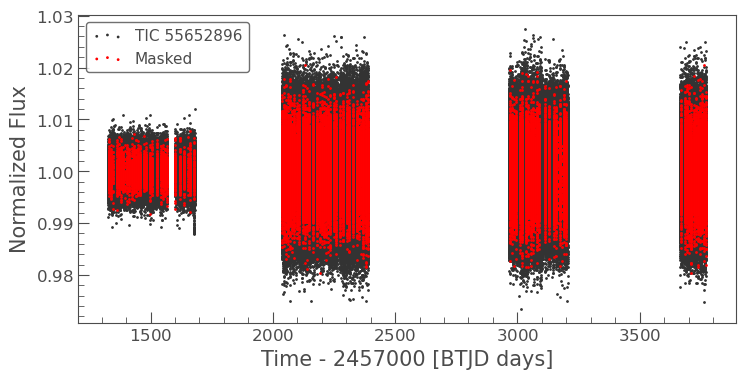

In [41]:
masked_lc_5 = masked_lc_4[~planet_5_mask]
ax = masked_lc_5.scatter();
masked_lc_4[planet_5_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [42]:
planet_5_model = bls_5.get_transit_model(period=planet_5_period,
                                       transit_time=planet_5_t0,
                                       duration=planet_5_dur)

`period` contains 223124 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


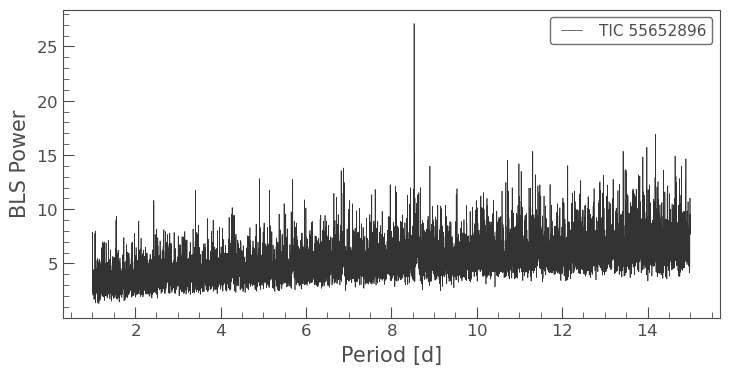

In [43]:
period = np.linspace(1, 15, 10000)
bls_6 = masked_lc_5.to_periodogram('bls', period=period, frequency_factor=500)
bls_6.plot()
plt.show()

In [44]:
planet_6_period = bls_6.period_at_max_power
planet_6_t0 = bls_6.transit_time_at_max_power
planet_6_dur = bls_6.duration_at_max_power

print(f"Best candidate period 6: {planet_6_period.value:.5f} days")
print(f"Best candidate t0 6: {planet_6_t0.value:.5f} days")

Best candidate period 6: 8.53415 days
Best candidate t0 6: 1333.98400 days


In [45]:
planet_6_mask = bls_6.get_transit_mask(period=planet_6_period,
                                     transit_time=planet_6_t0,
                                     duration=planet_6_dur*1.5)


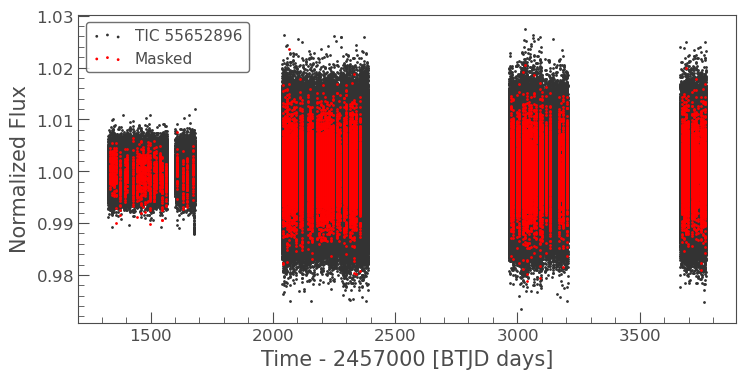

In [46]:
masked_lc_6 = masked_lc_5[~planet_6_mask]
ax = masked_lc_6.scatter();
masked_lc_5[planet_6_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [47]:
planet_6_model = bls_6.get_transit_model(period=planet_6_period,
                                       transit_time=planet_6_t0,
                                       duration=planet_6_dur)

## Transit models

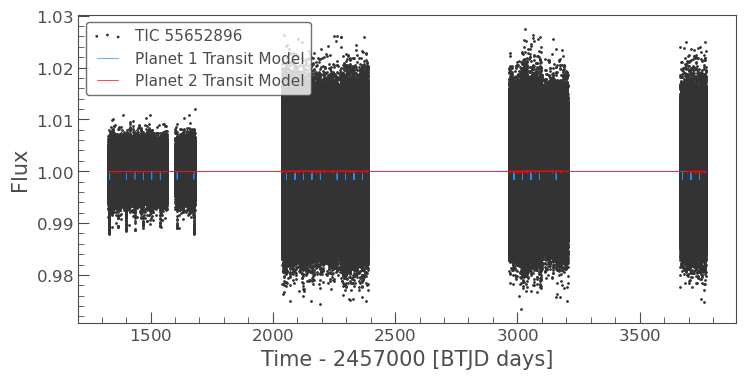

In [48]:
ax = combined_lc.scatter();
planet_1_model.plot(ax=ax, c='dodgerblue', label='Planet 1 Transit Model');
planet_2_model.plot(ax=ax, c='r', label='Planet 2 Transit Model');
# planet_3_model.plot(ax=ax, c='g', label='Planet 3 Transit Model');
# planet_4_model.plot(ax=ax, c='purple', label='Planet 4 Transit Model');
# planet_5_model.plot(ax=ax, c='orange', label='Planet 5? Transit Model');
# planet_6_model.plot(ax=ax, c='pink', label='Planet 6 Transit Model');

# plt.xlim(1340,1345)
# plt.ylim(0.998,1.002)
plt.show()

## Finding transit guess times based on models 

In [49]:
from scipy.signal import find_peaks

# Find all local minima (i.e., transit dips)
peaks_1, _ = find_peaks(-planet_1_model.flux.value, prominence=1e-5)
transit_times_1 = planet_1_model.time.value[peaks_1]
fluxes_1 = planet_1_model.flux.value[peaks_1]

print("Planet 1 transit dip times and depths:")
# for t, f in zip(transit_times_1, fluxes_1):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_1)

Planet 1 transit dip times and depths:
[1332.92379065 1401.81729255 1436.26715249 1470.71679593 1505.16771778
 1539.61315251 1608.51576169 1677.41644327 2194.16297361 2159.71259862
 2125.26291701 2090.81298245 2056.36378381 2090.87096909 2194.10822892
 2056.43728    2125.18502349 2159.66827009 2331.96227666 2263.06208814
 2366.41182256 2297.51252541 2366.3864751  2297.46819687 2263.08928689
 2332.00012395 3089.85424899 2986.50650188 3020.95667024 3055.40544078
 3158.75503164 3158.7549159  3055.40532504 3020.9553971  2986.50569171
 3089.85274435 3675.50162455 3675.50127733 3744.40198437 3709.95233238
 3744.40047976 3709.95221664]


In [50]:
# Find all local minima (i.e., transit dips)
peaks_2, _ = find_peaks(-planet_2_model.flux.value, prominence=1e-5)
transit_times_2 = planet_2_model.time.value[peaks_2]
fluxes_2 = planet_2_model.flux.value[peaks_2]

print("Planet 2 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_2)

Planet 2 transit dip times and depths:
[1331.42099472 1348.55868098 1365.9810495  1400.40201319 1417.65337365
 1434.81994371 1452.16700452 1469.32792333 1486.67214175 1521.1800179
 1538.38816494 1555.53246374 1607.45048031 1659.21344236 1676.46782063
 2211.34909328 2176.84255907 2193.97084638 2159.49176613 2125.01361143
 2090.53358174 2107.82490138 2038.80685691 2056.05498407 2090.5348549
 2107.82385971 2176.84036001 2193.97073064 2038.80650969 2056.05394239
 2211.34967198 2125.01280124 2159.49188187 2314.87382847 2332.20255493
 2245.85766213 2263.24472488 2366.68265844 2383.89279278 2297.72340425
 2366.68092231 2383.89082517 2297.72375147 2263.24484062 2245.85754639
 2314.87510162 2332.20290215 3074.0603857  3091.31513941 2970.53541086
 2987.65440388 3005.04359132 3022.29902203 3039.55126914 3056.80660687
 3160.33143909 3177.58601335 3143.07752667 3160.26743375 3177.58566613
 3143.07694796 3056.89005641 3022.33177643 3039.54698674 3005.04301263
 2970.53506364 2987.62651067 3074.060964

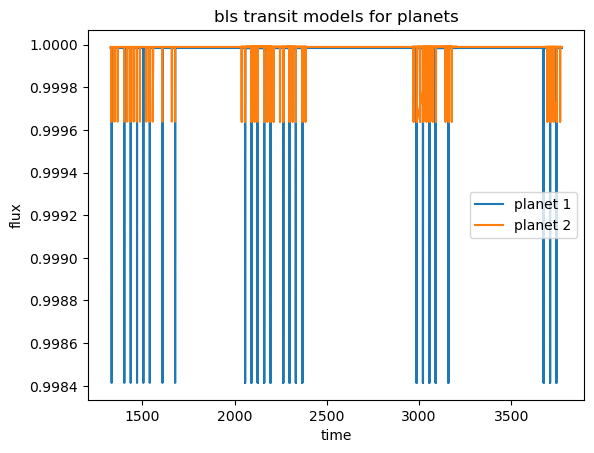

In [51]:
plt.plot(planet_1_model.time.value, planet_1_model.flux.value, label='planet 1')
plt.plot(planet_2_model.time.value, planet_2_model.flux.value, label='planet 2')

# plt.xlim(1335,1345)
# plt.xlim(1330,1350)
# plt.xlim(2100,2200)
# plt.xlim(1377,1380)
plt.title('bls transit models for planets')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

# Fit Transit Times

In [52]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

## Definitions

In [53]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t,tc1,chi_sq, err_threshold): 
    return np.interp(t, tc1, chi_sq) - err_threshold

In [54]:

def plot_chi_sq(time, flux, flux_err, tc, tc_guess, per, rp, b, T14, u1, u2):
    '''
    args:
        time: array of times from lightcurve
        flux: array of fluxes from lightcurve
        flux_err: array of flux errors from lightcurve
        tc: range of values around the guess time
        tc_guess: guess transit time
        per: period of planet
        rp: radius ratio (planet/star)
        b: impact parameter
        T14: transit duration
        u1, u2: limb darkening coefficients 
    '''
    ### plot X^2 vs tc for each guess
    for j in range(len(tc)):
        tc1 = tc[j]
        chi_sq = np.zeros(len(tc1))
        chi_sq_lc = np.zeros(len(tc1))
        for i in range(len(tc1)):
            t0_1 = 	tc1[i]
            theta_initial = [t0_1, per, rp, b, T14, u1, u2]
            
            ### initialize params
            params = batman.TransitParams()
            # params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
            # params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
            params.t0, params.per, params.rp,params.b, params.T14, u1, u2 = theta_initial
            params.u = [u1, u2] 
            params.limb_dark = 'quadratic'
            
            ### mask data - extract relevant photometry
            start = tc_guess[j] - ttv_hour
            end = tc_guess[j] + ttv_hour
            mask = (time > (start)) & (time < (end))
            
            transit_model = batman.TransitModel(params, time[mask])
                
            # Generate model light curve
            model_flux = transit_model.light_curve(params)
            
            # Calculate chi-squared value
            sigma2 = flux_err[mask] 
            chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
            chi_sq[i] = (chi_squared)
    
        ### masked
        min_chi_time = tc1[np.argmin(chi_sq)]
        min_chi = chi_sq.min()
    
        tc_chi[j] = min_chi_time
        # idx = transit_num[j]
        ttv[j] = min_chi_time - tc_guess[j]
    
        chi_mask = (chi_sq <= min_chi + 3)
        fit_mask = (chi_sq <= min_chi + 1)
    
        ### fit parabola to the chisq
        p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  
    
        ### Extract the coefficients   y = ax^2 + bx + c
        a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
        
        ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
        tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
        
        ### Calculate the minimum chi-squared value
        chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
        tc_chi_parabola[j] = tc_best_fit
    
        ### Calculate the parabola best fit 
        p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq
    
        ### calculate ttv from parabola fit 
        ttv_p[j] = tc_best_fit - tc_guess[j]
    
        ### delta chisq = 1 gives errors
        err_threshold = min_chi + 1 # using chisq discrete minimum
        err_threshold_p = chi_sq_min + 1 # using minimum of parabola
      
        # # Find the intersection using root_scalar
        # intersections = []
        # for k in range(len(tc1) - 1):
        #     if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections.append((sol.root - min_chi_time))
        # errors.append(intersections)
    
        # intersections_p = []
        # for k in range(len(tc1) - 1):
        #     if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections_p.append((sol.root - tc_best_fit))
        # errors_p.append(intersections_p)
    
        # plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
        # plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
        # plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
        # plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
        # plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')
    
        # # for inter in intersections:
        # #     plt.axvline(x=inter, color='blue', linestyle='--')
        # plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
        # plt.title(f'Transit {j+1}: Planet b')
        # plt.xlabel('tc')
        # plt.ylabel('X^2')
        # plt.legend()
        # plt.show()
    return tc_chi, ttv

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

def plot_transits(transit_times, per, rp, b, T14, u1, u2):
    cols = 3
    rows = int(np.ceil(len(transit_times) / cols))
    
    fig = plt.figure(figsize=(14, rows * 2.8))
    outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)
    
    for i, t0 in enumerate(transit_times):
        row = i // cols
        col = i % cols
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                                 height_ratios=[3, 1], hspace=0.0)  # Panels touch
    
        t_min = t0 - buffer
        t_max = t0 + buffer
        mask = (time >= t_min) & (time <= t_max)
        time_rel = time[mask] - t0  # Time relative to Tc
    
        # Transit model setup
        theta_initial = [t0, per, rp, b, T14, u1, u2]
        params = batman.TransitParams()
        params.t0, params.per, params.rp, params.b, params.T14, u1, u2 = theta_initial
        params.u = [u1, u2]
        params.limb_dark = 'quadratic'
    
        m = batman.TransitModel(params, time[mask])
        model_flux = m.light_curve(params)
        residuals = flux[mask] - model_flux
    
        # Top panel: model + data
        ax1 = fig.add_subplot(inner[0])
        ax1.scatter(time_rel, flux[mask], s=5, label='Data')
        ax1.plot(time_rel, model_flux, color='red', label='Model')
        ax1.axvline(0, color='green', linestyle='--', label='Tc')
        ax1.set_xlim(-buffer, buffer)
        ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{TESS_offset})')
        ax1.grid(True)
        ax1.tick_params(labelbottom=False)
    
        # Bottom panel: residuals
        ax2 = fig.add_subplot(inner[1], sharex=ax1)
        ax2.scatter(time_rel, residuals, s=5)
        ax2.axhline(0, color='red', linestyle='--', linewidth=1)
        ax2.set_xlim(-buffer, buffer)
        ax2.set_xlabel("Time from Tc [days]")
        ax2.grid(True)
    
        # Y-axis labels for first column only
        if col == 0:
            ax1.set_ylabel("Flux")
            ax2.set_ylabel("Residuals")
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=False)
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=False)
    
        # Custom ticks
        ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
        ax2.set_xticks(ticks)
    
    plt.show()


In [56]:
### stellar params
q1 = 0.44
q2 = 0.24

u1 = 2 * np.sqrt(q1) * q2
u2 = np.sqrt(q1) * (1 - 2 * q2)
print(u1)
print(u2)

0.3183959798741184
0.34492897819696156


## Planet 1

In [57]:
### Planet params (from exoplanet archive kipping et al 2019)
# planet b
per_1= 34.556
# per_1 = planet_1_period.value
rp_1= 0.1230
b_1= 0.15
T14_1= 5.514 * 0.0416667  # convert to days from hours


In [58]:
tc_guess_1 = transit_times_1
### get tc ranges for fit
tc_1 = []
for i in range(len(tc_guess_1)):
    start = tc_guess_1[i] - ttv_hour
    end = tc_guess_1[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_1.append(t)

In [59]:
### initialize arrays
tc_chi = np.zeros(len(tc_1))
tc_chi_parabola = np.zeros(len(tc_1))
ttv = np.zeros(len(tc_1))
ttv_p = np.zeros(len(tc_1))
errors = []
errors_p = []

In [60]:
tc_chi_1, ttv_1 = plot_chi_sq(time, flux, flux_err, tc_1, tc_guess_1, per_1, rp_1, b_1, T14_1, u1, u2)

/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipyker

In [61]:
print(tc_chi_1)

[1331.28014569 1400.36984394 1434.92380807 1469.4775557  1503.16771618
 1538.59012867 1607.70895424 1676.80983618 2194.16497561 2157.71259702
 2127.2589146  2090.80697644 2056.3537738  2090.80890697 2194.16628703
 2056.35119385 2127.18502509 2157.66826849 2332.69701198 2263.06008614
 2366.40982055 2295.51252381 2366.40849714 2295.46819527 2263.05925684
 2332.6948192  3090.3567519  2987.78578218 3021.29500885 3055.18722239
 3160.3986766  3160.39856086 3055.18710665 3021.29373571 2987.78497201
 3090.35925126 3676.37249612 3676.3721489  3746.40198597 3711.50388517
 3746.40048136 3711.50376943]


In [62]:
# Transit windows
buffer = 1.5 * T14_1
transit_times_1 = tc_chi_1

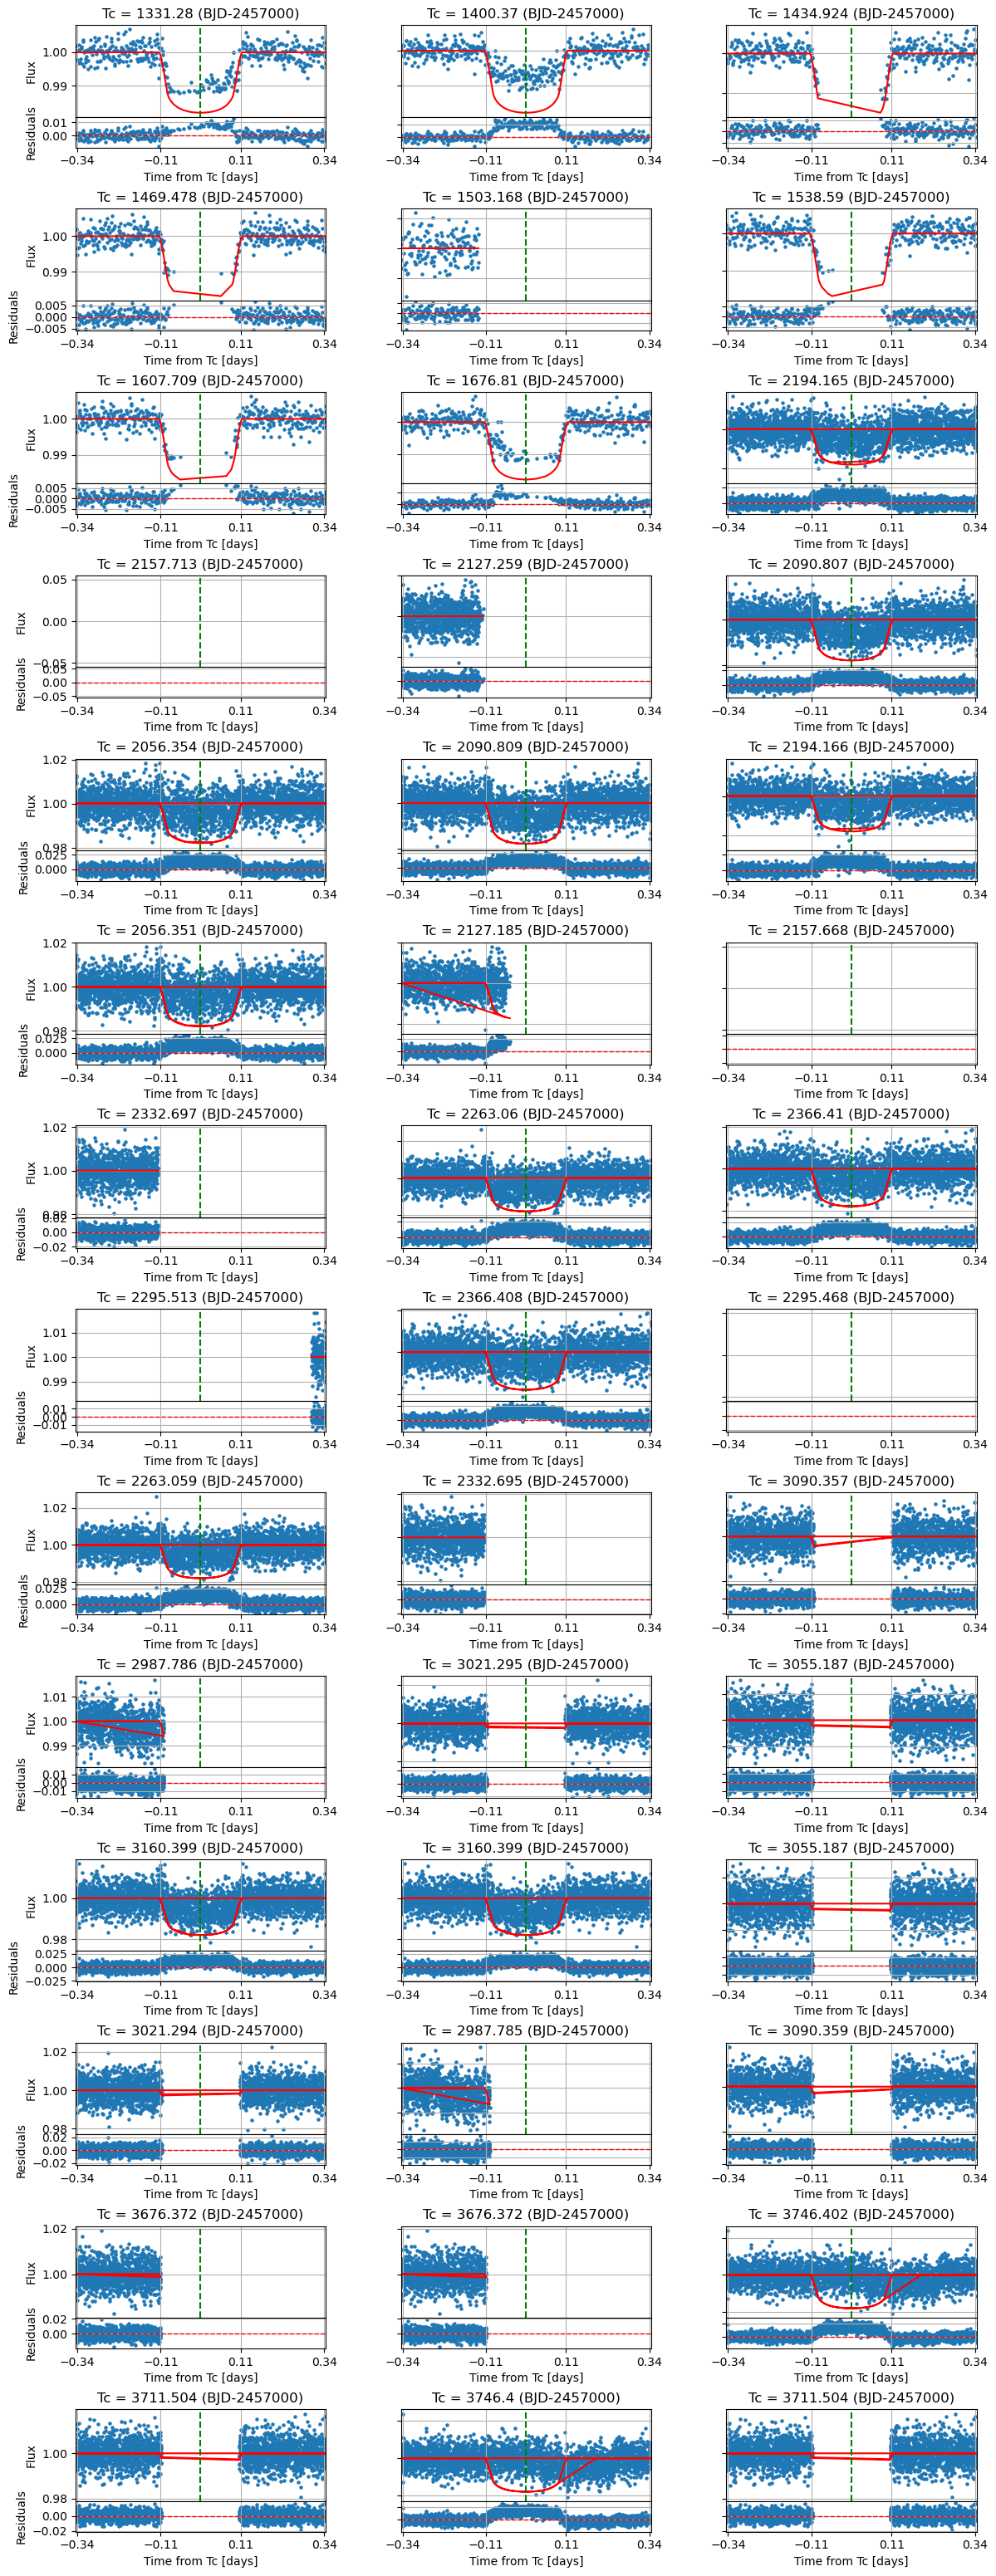

In [63]:
plot_transits(transit_times_1, per_1, rp_1, b_1, T14_1, u1, u2)

## Planet 2

In [64]:
### Planet params (from kipping et al 2019)
# planet b
per_2= 17.089
# per_2 = planet_2_period.value
rp_2= 0.0833
b_2= 0.948
T14_2= 2.062 * 0.0416667  # convert to days from hours


In [65]:
tc_guess_2 = transit_times_2
### get tc ranges for fit
tc_2 = []
for i in range(len(tc_guess_2)):
    start = tc_guess_2[i] - ttv_hour
    end = tc_guess_2[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_2.append(t)

In [66]:
### initialize arrays
tc_chi = np.zeros(len(tc_2))
tc_chi_parabola = np.zeros(len(tc_2))
ttv = np.zeros(len(tc_2))
ttv_p = np.zeros(len(tc_2))
errors = []
errors_p = []

In [67]:
tc_chi_2, ttv_2 = plot_chi_sq(time, flux, flux_err, tc_2, tc_guess_2, per_2, rp_2, b_2, T14_2, u1, u2)

/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_26032/295189538.py:59: RankWarning: Polyfit may be poorly conditioned
  p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipyker

In [68]:
print(tc_chi_2)

[1331.34291658 1348.04416605 1365.74281107 1400.37999115 1418.52824923
 1435.00613004 1451.63647357 1469.39398945 1486.13360278 1523.1800195
 1538.51028716 1555.58651784 1607.62865863 1658.31854675 1676.74209512
 2209.34909168 2178.84256067 2194.23711286 2159.65793243 2125.33193
 2090.86391233 2105.82489978 2040.80685851 2056.42535473 2090.86118149
 2105.82385811 2178.84036161 2194.23699712 2040.80651129 2056.42431306
 2209.34967038 2125.33512382 2159.65804817 2316.87383007 2331.98834055
 2247.85766373 2263.11859865 2366.47645207 2381.89279118 2297.44912976
 2366.47471594 2381.89082357 2297.44947698 2263.11871439 2247.85754799
 2316.87510322 2331.98868777 3075.99632318 3091.23706127 2969.50838301
 2987.57632573 3003.04358972 3022.16488779 3040.93865763 3056.82862891
 3160.45356131 3179.06549402 3141.07752507 3160.45362009 3179.06514679
 3141.07694636 3056.8279943  3022.16561013 3040.93837925 3003.04301103
 2969.50803579 2987.57646058 3075.99690189 3091.23749031 3731.72062913
 3746.6146

In [69]:
# Transit windows
buffer = 1.5 * T14_2
transit_times_2 = tc_chi_2

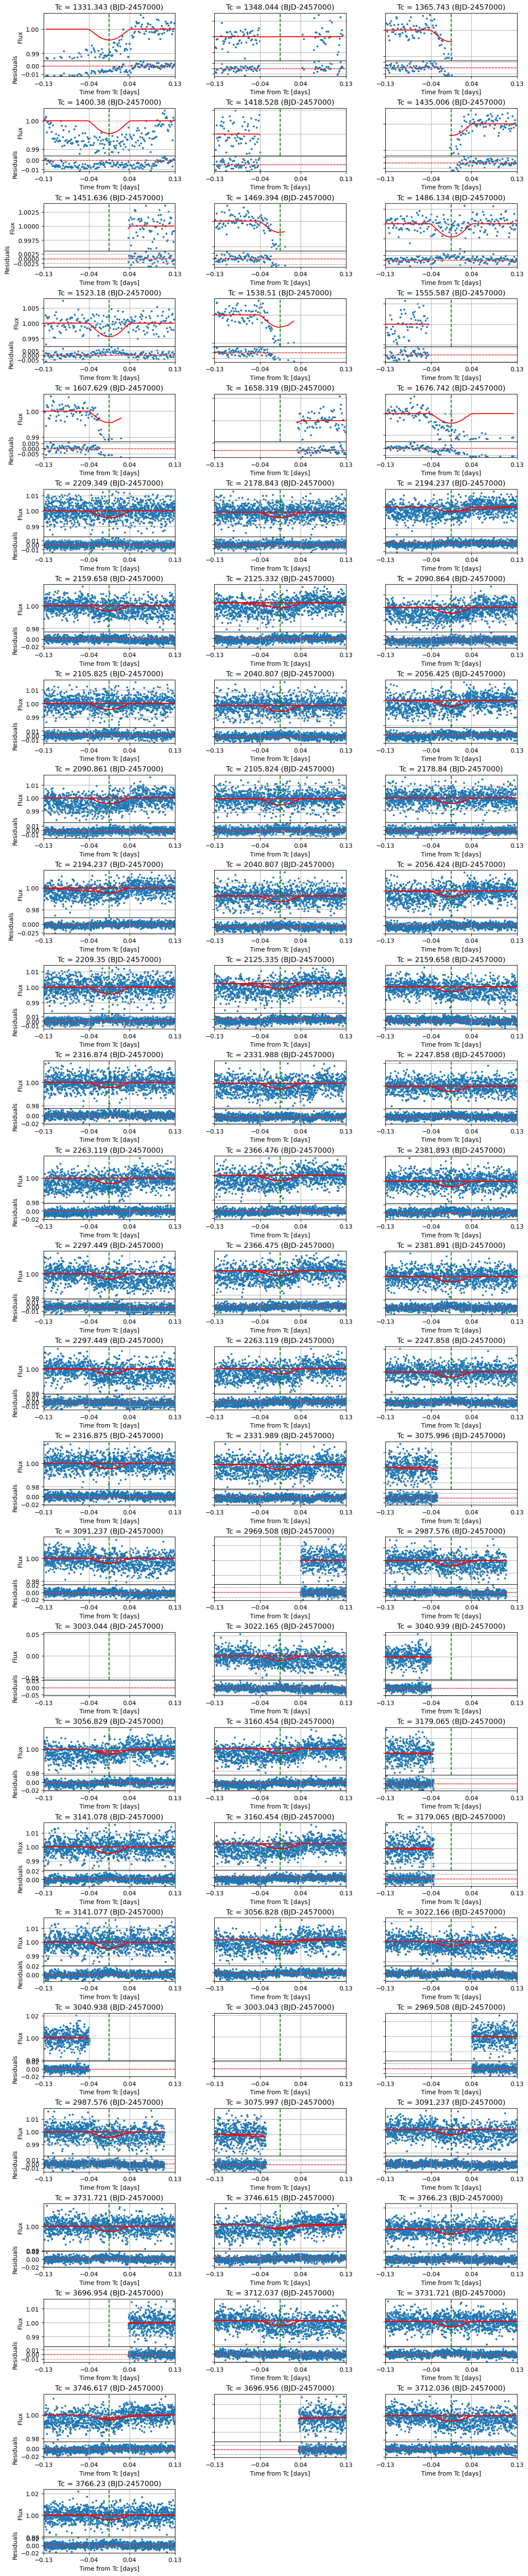

In [70]:
plot_transits(transit_times_2, per_2, rp_2, b_2, T14_2, u1, u2)

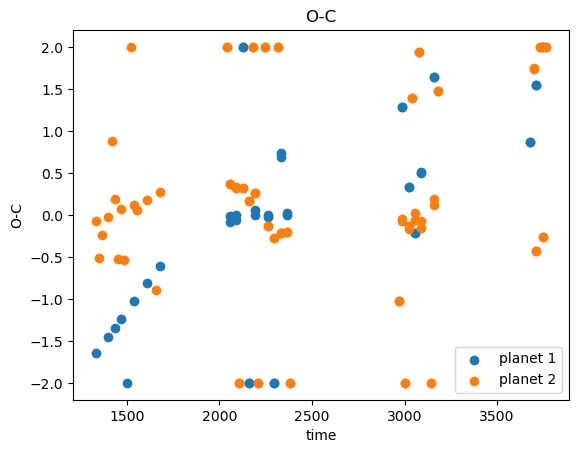

In [71]:
# TTV
plt.scatter(tc_chi_1, ttv_1, label='planet 1')
plt.scatter(tc_chi_2, ttv_2, label='planet 2')
plt.title('O-C')
plt.xlabel('time')
plt.ylabel('O-C')
plt.legend()
plt.show()

In [72]:
### Planet params (from barros et al 2022)
# planet e
per_3= 7.90754
rp_3= 0.01065
b_3= 0.50
T14_3= 2.48 * 0.0416667  # convert to days from hours


In [73]:
tc_guess_3 = transit_times_3
### get tc ranges for fit
tc_3 = []
for i in range(len(tc_guess_3)):
    start = tc_guess_3[i] - 6*ttv_hour
    end = tc_guess_3[i] + 6*ttv_hour
    t = np.linspace(start,end, 1000)
    tc_3.append(t)

NameError: name 'transit_times_3' is not defined

In [ ]:
### initialize arrays
tc_chi = np.zeros(len(tc_3))
tc_chi_parabola = np.zeros(len(tc_3))
ttv = np.zeros(len(tc_3))
ttv_p = np.zeros(len(tc_3))
errors = []
errors_p = []

In [ ]:
plot_chi_sq(time, flux, flux_err, tc_3, tc_guess_3, per_3, rp_3, b_3, T14_3, u1, u2)

In [ ]:
# Transit windows
buffer = 1.5 * T14_3
transit_times_3 = tc_chi
print(transit_times_3)

In [ ]:
plot_transits(transit_times_3, per_3, rp_3, b_3, T14_3, u1, u2)

In [ ]:
### Planet params (from barros et al 2022)
# planet d
per_4= 3.97664
rp_4= 0.009752
b_4= 0.47
T14_4= 1.99 * 0.0416667  # convert to days from hours


In [ ]:
tc_guess_4 = transit_times_4
### get tc ranges for fit
tc_4 = []
for i in range(len(tc_guess_4)):
    start = tc_guess_4[i] - ttv_hour
    end = tc_guess_4[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_4.append(t)

In [ ]:
### initialize arrays
tc_chi = np.zeros(len(tc_4))
tc_chi_parabola = np.zeros(len(tc_4))
ttv = np.zeros(len(tc_4))
ttv_p = np.zeros(len(tc_4))
errors = []
errors_p = []

In [ ]:
plot_chi_sq(time, flux, flux_err, tc_4, tc_guess_4, per_4, rp_4, b_4, T14_4, u1, u2)

In [ ]:
# Transit windows
buffer = 1.5 * T14_4
transit_times_4 = tc_chi
print(transit_times_4)

In [ ]:
plot_transits(transit_times_4, per_4, rp_4, b_4, T14_4, u1, u2)